# Check hardware information

In [1]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# !nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
# !lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
# !free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

False


# CFD Parameters

In [6]:
dt = 0.5
dx = 1.0
dy = 1.0
dz = 1.0
Re = 1/20
ub = 1
# nx = 512
# ny = 512
nx = 128
ny = 128
nz = 128
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 8
Aspect ratio of Domain: 1


# Weights of CNNs layers

In [7]:
diffusion = np.loadtxt('diffusion.csv', delimiter = ',')
advx = np.loadtxt('advection_x.csv', delimiter = ',')
advy = np.loadtxt('advection_y.csv', delimiter = ',')
advz = np.loadtxt('advection_z.csv', delimiter = ',')

In [8]:
D = -diffusion/dx**2
adv_x = advx/dx*0.5
adv_y = advy/dy*0.5
adv_z = advz/dz*0.5
A_mg = diffusion/dx**2

In [9]:
# adv_x = np.zeros([1,5,5,5,1])
# adv_xx = np.zeros([1,5,5,5,1])

# adv_y = np.zeros([1,5,5,5,1])
# adv_z = np.zeros([1,5,5,5,1])
# D = np.zeros([1,5,5,5,1])
# A_mg = np.zeros([1,5,5,5,1])

# for i in range(5):
#     print(i,i*5,(i+1)*5)
#     adv_x[0,i,:,:,0] = advx[i*5:(i+1)*5,0]*dt

# adv_x
w_res = np.zeros([1,2,2,2,1])
w_res[0,:,:,:,0] = 0.125

In [10]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)/dx
w2[0,1,:,:,0] = np.array(p_div_x2)/dx
w2[0,2,:,:,0] = np.array(p_div_x3)/dx

w3[0,0,:,:,0] = np.array(p_div_y1)/dx
w3[0,1,:,:,0] = np.array(p_div_y2)/dx
w3[0,2,:,:,0] = np.array(p_div_y3)/dx 

w4[0,0,:,:,0] = np.array(p_div_z1)/dx 
w4[0,1,:,:,0] = np.array(p_div_z2)/dx
w4[0,2,:,:,0] = np.array(p_div_z3)/dx

In [11]:
kernel_initializer_D = tf.keras.initializers.constant(D)
kernel_initializer_adv_x = tf.keras.initializers.constant(adv_x)
kernel_initializer_adv_y = tf.keras.initializers.constant(adv_y)
kernel_initializer_adv_z = tf.keras.initializers.constant(adv_z)
kernel_initializer_w_res = tf.keras.initializers.constant(w_res)
kernel_initializer_A_mg = tf.keras.initializers.constant(A_mg)

kernel_initializer_adv_x_3 = tf.keras.initializers.constant(w2)
kernel_initializer_adv_y_3 = tf.keras.initializers.constant(w3)
kernel_initializer_adv_z_3 = tf.keras.initializers.constant(w4)

bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [11]:
central_xadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_x_3,
                                bias_initializer=bias_initializer),
])

central_yadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_y_3,
                                bias_initializer=bias_initializer),
])

central_zadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_z_3,
                                bias_initializer=bias_initializer),
])

In [12]:
central_dif_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_D,
                                bias_initializer=bias_initializer),
])

central_xadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_x,
                                bias_initializer=bias_initializer),
])

central_yadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_y,
                                bias_initializer=bias_initializer),
])

central_zadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_z,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [13]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_A_mg,
                                bias_initializer=bias_initializer)
    ])

In [14]:
for i in range(nlevel-1):
    locals()['restrict_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_w_res,
                                bias_initializer=bias_initializer),   
    ])    

In [15]:
for i in range(nlevel-1):
    locals()['prolongate_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*ratio*2**i, 1*ratio*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [16]:
def boundary_condition_velocity(values_u,values_v,values_w):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    
    # print(tempu[0,:,:,0:2,0].shape)
    
    tempu[0,:,:,0:2,0].assign(tf.Variable(tf.ones((nz,ny,2)))*ub) 
    tempv[0,:,:,0:2,0].assign(tf.Variable(tf.zeros((nz,ny,2))))    
    tempw[0,:,:,0:2,0].assign(tf.Variable(tf.zeros((nz,ny,2))))   

    tempu[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.ones((nz,ny,2)))*ub) 
    tempv[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2))))   
    tempw[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2))))  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,2,:,0]) 
    tempu[0,:,1,:,0].assign(tf.Variable(values_u)[0,:,2,:,0]) 
    tempv[0,:,0:2,:,0].assign(tf.Variable(tf.zeros((nz,2,nx))))  
    tempw[0,:,0:2,:,0].assign(tf.Variable(tf.zeros((nz,2,nx))))  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-3,:,0])    
    tempu[0,:,nx-2,:,0].assign(tf.Variable(values_u)[0,:,nx-3,:,0])    
    tempv[0,:,nx-2:nx,:,0].assign(tf.Variable(tf.zeros((nz,2,nx))))     
    tempw[0,:,nx-2:nx,:,0].assign(tf.Variable(tf.zeros((nz,2,nx))))  
    
    tempu[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx))))     
    tempv[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx))))  
    tempw[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx))))  
 
    tempu[0,nz-1,:,:,0].assign(tf.Variable(values_u)[0,nz-3,:,:,0])   
    tempu[0,nz-2,:,:,0].assign(tf.Variable(values_u)[0,nz-3,:,:,0])       
    tempv[0,nz-1,:,:,0].assign(tf.Variable(values_v)[0,nz-3,:,:,0]) 
    tempv[0,nz-2,:,:,0].assign(tf.Variable(values_v)[0,nz-3,:,:,0])       
    tempw[0,nz-2:nz,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx))))      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,2,0]) 
    tempp[0,:,:,1,0].assign(tf.Variable(values_p)[0,:,:,2,0])     
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,2,:,0]) 
    tempp[0,:,1,:,0].assign(tf.Variable(values_p)[0,:,2,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0])  
    tempp[0,:,nx-2,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0]) 

    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0]) 
    tempp[0,1,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0])     
    tempp[0,nz-1,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0])    
    tempp[0,nz-2,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0]) 
#     tempp[0,:,:,0:2,0].assign(tf.Variable(values_p)[0,:,:,2,0])
    
#     tempp[0,:,0:2,:,0].assign(tf.Variable(values_p)[0,:,2,:,0])     
#     tempp[0,:,nx-2:nx,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0]) 
    
#     tempp[0,0:2,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0])     
#     tempp[0,nz-2:nz,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,2,0])
    tempb[0,:,:,1,0].assign(tf.Variable(b)[0,:,:,2,0])

    return tempb

def bluff_body(values_u,values_v,values_w,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

def save_data(n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("../Data_Results/INHALE_512_555_3/u"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("../Data_Results/INHALE_512_555_3/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("../Data_Results/INHALE_512_555_3/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("../Data_Results/INHALE_512_555_3/p"+str(itime), arr=values_p[0,:,:,:,0])

In [17]:
def Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_u)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_u)) + 
                               abs(central_yadv_5th(values_u)) + 
                               abs(central_zadv_5th(values_u)))/3)
    
    k_v = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_v)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_v)) + 
                               abs(central_yadv_5th(values_v)) + 
                               abs(central_zadv_5th(values_v)))/3)
    
    k_w = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_w)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_w)) + 
                               abs(central_yadv_5th(values_w)) + 
                               abs(central_zadv_5th(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*central_dif_5th(values_u) +
                central_dif_5th(values_u*k_u) -
                values_u*central_dif_5th(k_u))


    k_y = 3*0.5*(k_v*central_dif_5th(values_v) + 
                central_dif_5th(values_v*k_v) -
                values_v*central_dif_5th(k_v))


    k_z = 3*0.5*(k_w*central_dif_5th(values_w) + 
                central_dif_5th(values_w*k_w) -
                values_w*central_dif_5th(k_w))

    return k_x, k_y, k_z

In [18]:
def Petrov_Galerkin_dissipation_high(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8*0.25*abs(values_u*(central_xadv_5th(values_u)-central_xadv_3th(values_u))+
                     values_v*(central_yadv_5th(values_u)-central_yadv_3th(values_u))+
                     values_w*(central_zadv_5th(values_u)-central_zadv_3th(values_u)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_u))+ \
                      abs(central_yadv_5th(values_u))+abs(central_zadv_5th(values_u)))/3)

    k_v = 8*0.25*abs(values_u*(central_xadv_5th(values_v)-central_xadv_3th(values_v))+
                     values_v*(central_yadv_5th(values_v)-central_yadv_3th(values_v))+
                     values_w*(central_zadv_5th(values_v)-central_zadv_3th(values_v)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_v))+ \
                      abs(central_yadv_5th(values_v))+abs(central_zadv_5th(values_v)))/3)
    
    k_w = 8*0.25*abs(values_u*(central_xadv_5th(values_w)-central_xadv_3th(values_w))+
                     values_v*(central_yadv_5th(values_w)-central_yadv_3th(values_w))+
                     values_w*(central_zadv_5th(values_w)-central_zadv_3th(values_w)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_w))+ \
                      abs(central_yadv_5th(values_w))+abs(central_zadv_5th(values_w)))/3)
    
    
    
    
#     k_v = 40 * 0.25 * abs(1/3*
#                                (abs(values_u) + abs(values_v) + abs(values_w)) * 
#                                central_dif_5th(values_v)) / (eplsion_k + 
#                                (abs(central_xadv_5th(values_v)) + 
#                                abs(central_yadv_5th(values_v)) + 
#                                abs(central_zadv_5th(values_v)))/3)
    
#     k_w = 40 * 0.25 * abs(1/3*
#                                (abs(values_u) + abs(values_v) + abs(values_w)) * 
#                                central_dif_5th(values_w)) / (eplsion_k + 
#                                (abs(central_xadv_5th(values_w)) + 
#                                abs(central_yadv_5th(values_w)) + 
#                                abs(central_zadv_5th(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*central_dif_5th(values_u) +
                central_dif_5th(values_u*k_u) -
                values_u*central_dif_5th(k_u))


    k_y = 3*0.5*(k_v*central_dif_5th(values_v) + 
                central_dif_5th(values_v*k_v) -
                values_v*central_dif_5th(k_v))


    k_z = 3*0.5*(k_w*central_dif_5th(values_w) + 
                central_dif_5th(values_w*k_w) -
                values_w*central_dif_5th(k_w))

    return k_x, k_y, k_z

# Initialise

============== Numerical parameters ===============
Mesh resolution: (1, 128, 128, 128, 1)
Time step: 5
Initial time: 0
Solving single-phase flows!
Switch on IBM solver!


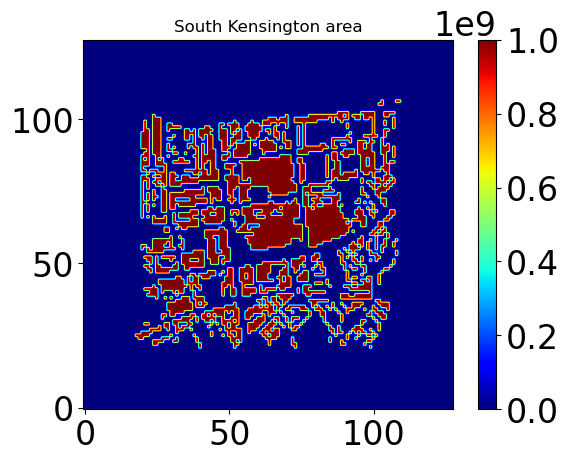

In [19]:
#################### Create field #####£###############
input_shape = (1,nz,ny,nx,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 4               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 5                 # Time steps
n_out = 1000                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = False              # Scalar transport 
LMTI = False                 # Non density for multiphase flows
LIBM = True                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = False             # Save results
Restart = False             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 980                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.8   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('../Data_Results/data_SK_quartic/u500.npy').astype('float32')
    temp2 = np.load('../Data_Results/data_SK_quartic/v500.npy').astype('float32')
    temp3 = np.load('../Data_Results/data_SK_quartic/w500.npy').astype('float32')
    temp4 = np.load('../Data_Results/data_SK_quartic/p500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,0:64,:,:,0] = 0
    alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    # mesh = np.load('../Mesh_SK_London/INHALE_640.npy')
    mesh = np.load('../examples/master/mesh_64_sk.npy') # replace with 128x128x128 case
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                # if mesh[0][i+64][j+64][k][0] == 0:
                if mesh[0][i+16][j+16][k][0] == 0: # change to valid shape
                    sigma[0][k][j][i][0] = 1000000000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
    plt.gca().invert_yaxis()
#######################################################

### Hide blocks

In [20]:
#     sigma = np.zeros(input_shape).astype('float32')

In [21]:
# # test for petrov-galerkin case 
# values = tf.zeros(input_shape)
# T = np.zeros(input_shape).astype('float32')
# T[0,54:74,54:74,54:74,0] = 1
# T = tf.convert_to_tensor(T)
# values_u = T

In [22]:
# plt.imshow((values_u)[0,64,:,:,0], cmap='RdBu')
# plt.colorbar()

In [23]:
# for t in range(100):
#     values_u = values_u - CNN3D_central_2nd_xadv(values_u)

In [24]:
# for t in range(1000):
#     values_u = values_u + CNN3D_central_2nd_dif(values_u)

In [25]:
# for t in range(100):
#     values_u = values_u + CNN3D_central_2nd_dif(values_u) - CNN3D_central_2nd_xadv(values_u)

In [26]:
# for t in range(100):
#     [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
#     values_u = values_u + k_x - CNN3D_central_2nd_xadv(values_u)

# AI-HFM Solver

In [27]:
start = time.time()

# 7000 timesteps in total
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    values_p = boundary_condition_pressure(values_p,nx)# Petrov-Galerkin dissipation
    [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)# Momentum equation 
    # print(k_x.shape, k_y.shape, k_z.shape)
    a_u = k_x*dt*Re - \
    values_u*central_xadv_5th(values_u)*dt - \
    values_v*central_yadv_5th(values_u)*dt - \
    values_w*central_zadv_5th(values_u)*dt
    b_u = 0.5*a_u + values_u
    a_v = k_y*dt*Re - \
    values_u*central_xadv_5th(values_v)*dt - \
    values_v*central_yadv_5th(values_v)*dt - \
    values_w*central_zadv_5th(values_v)*dt
    b_v = 0.5*a_v + values_v
    a_w = k_z*dt*Re - \
    values_u*central_xadv_5th(values_w)*dt - \
    values_v*central_yadv_5th(values_w)*dt - \
    values_w*central_zadv_5th(values_w)*dt 
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w)
    [kb_x,kb_y,kb_z] = Petrov_Galerkin_dissipation(b_u, b_v, b_w, eplsion_k, sigma)

    c_u = kb_x*dt*Re - \
    b_u*central_xadv_5th(b_u)*dt - \
    b_v*central_yadv_5th(b_u)*dt - \
    b_w*central_zadv_5th(b_u)*dt
    values_u = values_u + c_u      
    c_v = kb_y*dt*Re - \
    b_u*central_xadv_5th(b_v)*dt - \
    b_v*central_yadv_5th(b_v)*dt - \
    b_w*central_zadv_5th(b_v)*dt 
    values_v = values_v + c_v
    c_w = kb_z*dt*Re - \
    b_u*central_xadv_5th(b_w)*dt - \
    b_v*central_yadv_5th(b_w)*dt - \
    b_w*central_zadv_5th(b_w)*dt 
    values_w = values_w + c_w    
    
# Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
        
# Suppose we are using IB method in this case
# IBM
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# gradp            
    values_u = values_u - central_xadv_5th(values_p)*dt
    values_v = values_v - central_yadv_5th(values_p)*dt  
    values_w = values_w - central_zadv_5th(values_p)*dt     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
# possion equation (multi-grid) A*P = Su
    b = -(central_xadv_5th(values_u) + \
          central_yadv_5th(values_v) + \
          central_zadv_5th(values_w))/dt
    b = boundary_condition_source(b,nx)
    
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,ratio,ratio,1])
            r = CNN3D_A_128(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
#             r_128 = CNN3D_res_256(r_256) 
            r_64 = restrict_128(r) 
            r_32 = restrict_64(r_64) 
            r_16 = restrict_32(r_32) 
            r_8 = restrict_16(r_16) 
            r_4 = restrict_8(r_8) 
            r_2 = restrict_4(r_4) 
            r_1 = restrict_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/A_mg[12,2] + r_1/A_mg[12,2])
            w_2 = prolongate_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/A_mg[12,2] + r_2/A_mg[12,2])
            w_4 = prolongate_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/A_mg[12,2] + r_4/A_mg[12,2])
            w_8 = prolongate_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/A_mg[12,2] + r_8/A_mg[12,2])
            w_16 = prolongate_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/A_mg[12,2] + r_16/A_mg[12,2])
            w_32 = prolongate_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/A_mg[12,2] + r_32/A_mg[12,2])
            w_64 = prolongate_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/A_mg[12,2] + r_64/A_mg[12,2])
            w_128 = prolongate_64(w_64) 
#             for Jacobi in range(j_itr):
#                 w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
#             w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_128
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])         
            values_p = (values_p - CNN3D_A_128(values_p)/A_mg[12,2] + b/A_mg[12,2])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - central_xadv_5th(values_p)*dt
    values_v = values_v - central_yadv_5th(values_p)*dt  
    values_w = values_w - central_zadv_5th(values_p)*dt      
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_128), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_128)) > nsafe:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

Time step: 1
Pressure error: 0.070625246 cty equation residual: 0.20409054


In [ ]:
np.save("Data_Results/INHALE_512_555_3/u"+str(itime), arr=values_u[0,:,:,:,0])
np.save("Data_Results/INHALE_512_555_3/v"+str(itime), arr=values_v[0,:,:,:,0])
np.save("Data_Results/INHALE_512_555_3/w"+str(itime), arr=values_w[0,:,:,:,0])
np.save("Data_Results/INHALE_512_555_3/p"+str(itime), arr=values_p[0,:,:,:,0])

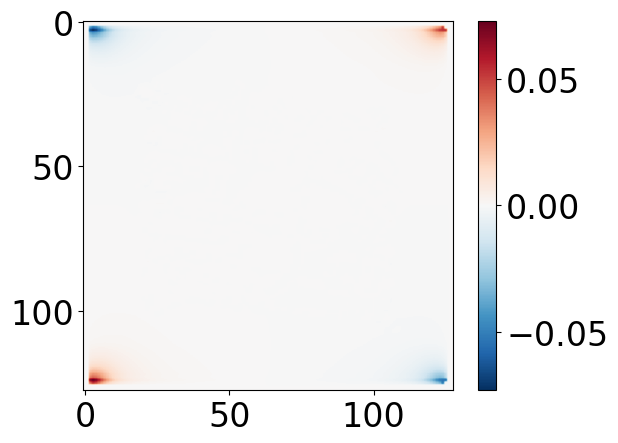

In [ ]:
plt.imshow((values_v)[0,2,:,:,0], cmap='RdBu_r')
plt.colorbar()

In [ ]:
# np.save("scaling fiter"+str(itime), arr=mag1)
# np.save("enlarging pg"+str(itime), arr=mag)

In [ ]:
#    mag1 = np.load('scaling fiter4000.npy').astype('float32')
# mag = np.load('enlarging pg4000.npy').astype('float32')

In [ ]:
# mag1 = (values_u**2+values_v**2+values_w**2)**0.5

In [ ]:
# mag = (values_u**2+values_v**2+values_w**2)**0.5

In [ ]:
# np.save("scaling fiter"+str(itime), arr=mag1)
# np.save("enlarging pg"+str(itime), arr=mag)

In [ ]:
# fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# plt.subplot(2,4,1)
# plt.imshow((mag1)[0,2,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 2', fontsize=25)
# plt.subplot(2,4,2)
# plt.imshow((mag1)[0,10,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 10', fontsize=25)
# plt.subplot(2,4,3)
# plt.imshow((mag1)[0,20,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 20', fontsize=25)
# plt.subplot(2,4,4)
# plt.imshow((mag1)[0,30,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 30', fontsize=25)

# plt.subplot(2,4,5)
# plt.imshow((mag)[0,2,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 2', fontsize=25)
# plt.subplot(2,4,6)
# plt.imshow((mag)[0,10,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 10', fontsize=25)

# plt.subplot(2,4,7)
# plt.imshow((mag)[0,20,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 20', fontsize=25)
# plt.subplot(2,4,8)
# plt.imshow((mag)[0,30,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('z = 30', fontsize=25)

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 10))


# plt.subplot(1,4,1)
# plt.imshow((mag1-mag)[0,2,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('Z = 2', fontsize=40)
# plt.subplot(1,4,2)
# plt.imshow((mag1-mag)[0,10,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('Z = 10', fontsize=40)

# plt.subplot(1,4,3)
# plt.imshow((mag1-mag)[0,20,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('Z = 20', fontsize=40)
# plt.subplot(1,4,4)
# plt.imshow((mag1-mag)[0,30,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# # plt.colorbar()
# plt.axis('off') 
# plt.title('Z = 30', fontsize=40)



In [ ]:
# plt.imshow((mag)[0,2,:,:,0], cmap='RdBu_r')
# plt.colorbar()

In [ ]:
# plt.imshow((mag)[0,30,:,:,0], cmap='RdBu_r')
# plt.colorbar()

In [ ]:
# plt.imshow((values_p)[0,5,:,:,0], cmap='RdBu_r')
# plt.colorbar()